<a href="https://colab.research.google.com/github/syamkakarla98/Hyperspectral_Image_Analysis_Simplified/blob/master/Articles/Hyperspectral_Image_Analysis%E2%80%8A_%E2%80%8AClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Indian Pines Satellite Image Analysis - Classification

You can use this notebook to write the ML pipeline for the classification of Indian pines based on the analysis of satellite images or you can create a folder with different files associated to the different steps of the ML pipeline.

## Import Libraries

In [1]:
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#import Random forest classifiers
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

## Download HSI Data

In [2]:
!ls

Classifying_galaxies_in_GALAXYZOO.ipynb
Classifying_objects_in_FashionMNIST.ipynb
Data_satellite
Indian_pines_classification.ipynb
Readme.md


## Read the Data

In [4]:
from scipy.io import loadmat

def read_HSI():
  X = loadmat('data/Indian_pines_corrected.mat')['indian_pines_corrected']
  y = loadmat('data/Indian_pines_gt.mat')['indian_pines_gt']
  print(f"X shape: {X.shape}\ny shape: {y.shape}")
  return X, y

X, y = read_HSI()

X shape: (145, 145, 200)
y shape: (145, 145)


### Visualize Bands

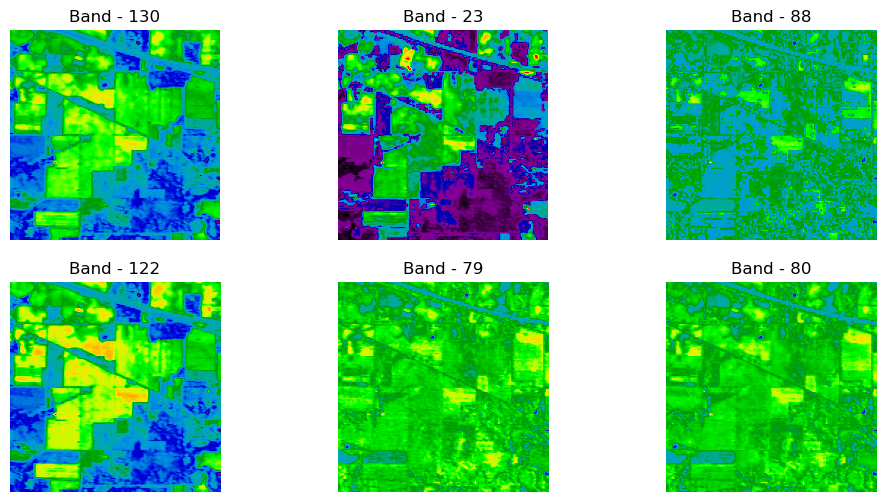

In [5]:
fig = plt.figure(figsize = (12, 6))

for i in range(1, 1+6):
    fig.add_subplot(2,3, i)
    q = np.random.randint(X.shape[2])
    plt.imshow(X[:,:,q], cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {q}')
plt.savefig('IP_Bands.png')

### Visualize the Ground Truth

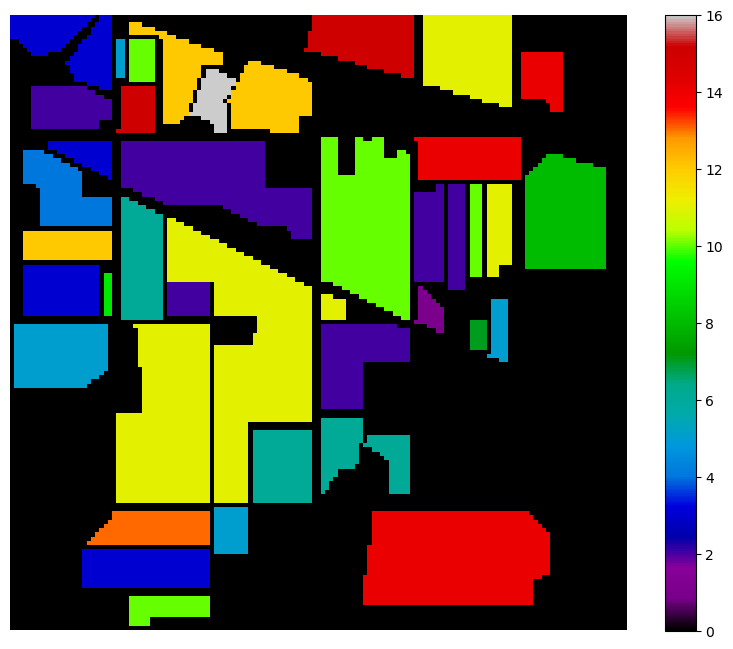

In [6]:
plt.figure(figsize=(10, 8))
plt.imshow(y, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.savefig('IP_GT.png')
plt.show()

## Convert the dataset into csv 

In [7]:
import pandas as pd
import numpy as np

def extract_pixels(X, y):
  q = X.reshape(-1, X.shape[2])
  df = pd.DataFrame(data = q)
  df = pd.concat([df, pd.DataFrame(data = y.ravel())], axis=1)
  df.columns= [f'band{i}' for i in range(1, 1+X.shape[2])]+['class']
  df.to_csv('Dataset.csv')
  return df
  
df = extract_pixels(X, y)


# EDA 

Perform exploratory data analysis on the tabular data

## Principal Component Analysis(PCA)


STEPS

1. Estimate the basis of Principal components

2. Plot the cumulative explained variance associated with Principal components VS Number of components.

3. Select acordingly the no.of components for PCA projection

4. Reconstruct the images associated to the different bands using the selected principal components

## Plot reconstructed images in different bands

In [2]:
#fig = plt.figure(figsize = (20, 10))



#plt.savefig('IP_PCA_Bands.png')

In [15]:
# saving to .csv
q.to_csv('IP_40_PCA.csv', index=False)

## Classification with RF (optional: comparison with other classifiers)

In [99]:
#Use the names below for the classes sorted


names = ['Alfalfa','Corn-notill', 'Corn-mintill','Corn','Grass-pasture','Grass-trees',
'Grass-pasture-mowed','Hay-windrowed','Oats','Soybean-notill','Soybean-mintill',
'Soybean-clean', 'Wheat','Woods','Buildings Grass Trees Drives','Stone Steel Towers']


#SPLIT DATA in TRAINING and testing

#Define classifier

#Fit and predict
#ypred = classifier.predict(X_test)

In [3]:
#PLOT THE CONFUSION MATRIX Associate to the classifier

#data = confusion_matrix(y_test, ypred)
#df_cm = pd.DataFrame(data, columns=np.unique(names), index = np.unique(names))
#plt.savefig('cmap.png', dpi=300)

In [1]:
#print(classification_report(y_test, ypred, target_names = names))

## Classification Map

In [4]:
#Use the function below to produce the classification map


def reconstruct_classification_map(q, classifier):
    l=[]
    for i in range(q.shape[0]):
      if q.iloc[i, -1] == 0:
        l.append(0)
      else:
        l.append(classifier.predict(q.iloc[i, :-1].values.reshape(1, -1)))
    return l


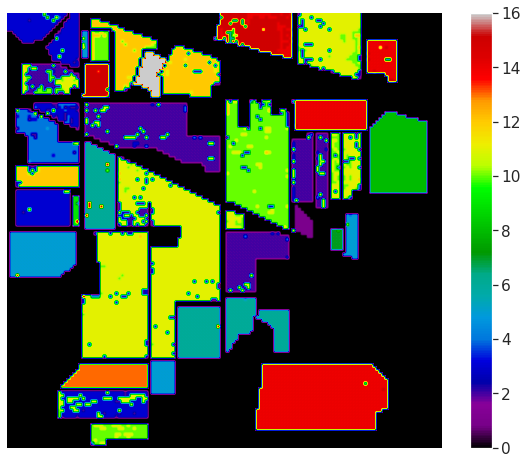

In [129]:
clmap = np.array(l).reshape(145, 145).astype('float')
plt.figure(figsize=(10, 8))
plt.imshow(clmap, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.savefig('IP_cmap.png')
plt.show()



---



---

